<a href="https://colab.research.google.com/github/PrasanthGubbala/Colab/blob/dev/Course1/Project1/Part_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project : Analysis of job market data to explore the open positions related to the jobs in the field of data or machine learning in a particular region

# 1)	Data Collection

In [ ]:
import csv
from datetime import datetime
import requests
from bs4 import BeautifulSoup

from selenium import webdriver
import time
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import math
import time

import requests
from datetime import datetime
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

driver_path = "C:/Users/3661481/OneDrive - Lowe's Companies Inc/WORK/Projects/Push Candidate/Test_project/edgedriver_win64/msedgedriver.exe"


def get_url(position=None, location=None):
    """Generate a url from position and location"""
    return f'https://www.linkedin.com/jobs/search/?keywords={position}&location={location}'



def get_more_details_for_a_job(url, record):
#     print(f'creating another request for deep details for job - job_url: {url}')
    response = requests.get(url, verify=False)
    if response.status_code==429:
        print(f'Response status_code:{response.status_code} ','waiting 2 secs for another request')
        time.sleep(2)
        return get_more_details_for_a_job(url, record)

    elif response.status_code==200:
        soup = BeautifulSoup(response.text, 'html.parser')

        try:
            no_of_applications = soup.find('figcaption', 'num-applicants__caption').get_text().strip()
        except AttributeError:
            no_of_applications = None

        data_pull_time = datetime.now()

        try:
            jd = soup.find('div', 'show-more-less-html__markup show-more-less-html__markup--clamp-after-5 relative overflow-hidden')
        except AttributeError:
            jd = None

        description__job_criteria_list = soup.find_all('li', 'description__job-criteria-item')
        criterias = {}
        for criteria in description__job_criteria_list:
            try:
                key = criteria.find('h3','description__job-criteria-subheader').get_text().strip()
            except AttributeError:
                continue
            try:
                value = criteria.find('span', 'description__job-criteria-text description__job-criteria-text--criteria').get_text().strip()
            except AttributeError:
                value = None
            criterias.update({key:value})

        record['no_of_applications'] = no_of_applications
        record['data_pull_time'] = data_pull_time
        record['jd'] = jd
        record['criterias'] = criterias

        return record

    else:
        raise Exception(f'request failed, status_code:{response.status_code}, response: {response.text}')

def get_record(card):
    """Extract job data from a single record"""

    '''define all values'''
    try:
        job_link = card.find('a', 'base-card__full-link').get('href')
    except AttributeError:
        job_link = None

    try:
        job_role = card.find('h3', 'base-search-card__title').get_text().strip()
    except AttributeError:
        job_role = None


    company = card.find('h4', 'base-search-card__subtitle')  #div.h4.text.strip()

    try:
        company_name = company.a.get_text().strip()
    except AttributeError:
        company_name = None

    try:
        company_url = company.find('a').get('href')
    except AttributeError:
        company_url = None

    try:
        job_location = card.find('span', 'job-search-card__location').text.strip()
    except AttributeError:
        job_location = None

    try:
        hiring_status = card.find('span', 'result-benefits__text').text.strip()
    except AttributeError:
        hiring_status = None
    try:
        job_posting_date = card.find('time', class_='job-search-card__listdate')['datetime']
    except TypeError:
        job_posting_date = None
    try:
        job_salary = card.find('span', 'job-search-card__salary-info').get_text().strip()
    except AttributeError:
        job_salary = None

    record = {'role':job_role,
              'company_name':company_name,
              'location':job_location,
              'hiring_status':hiring_status,
              'job_posting_date':job_posting_date,
              'job_link':job_link,
              'company_url':company_url
             }

    if job_link:
        record = get_more_details_for_a_job(job_link, record)

    return record

def scroll_down(driver):
    # Scroll down to the bottom of the page
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    scroll_height = driver.execute_script("return document.body.scrollHeight;")

    return scroll_height

def load_all_items(driver):
    print('Scrolling down to load all the items:')
    screen_height = scroll_down(driver)
    while True:
        print('prevoius page height:',screen_height)
        time.sleep(3)
        screen_height_next = scroll_down(driver)
        print('current page height:',screen_height_next)
        if screen_height==screen_height_next:
            print('previous and current pages are same, finally no more items to scroll down!.')
            break
        else:
            screen_height=screen_height_next

def load_more_items(driver,no_of_items=0):
    print('cliciking load more items button!.')
    click = 1
    for i in range(no_of_items):
        driver.find_element_by_xpath("//button[@aria-label='See more jobs']").click()
#         print('ckick no :',click)
        click+=1
    print('total no of ckicks on more items button:',click)

def main(driver_path, position, location, no_of_items=0):
    """Run the main program routine"""
    records = []
    url = get_url(position, location)
    driver = webdriver.Edge(executable_path=driver_path)
    driver.get(url)
    driver.maximize_window()
    time.sleep(1)
    load_all_items(driver)
#     load_more_items(driver, no_of_items=no_of_items)
#     load_all_items(driver)


    # Get the HTML content after scrolling
    html_content = driver.page_source

    soup = BeautifulSoup(html_content, 'html.parser')

    # Find the <ul> element with class "jobs-search__results-list"
    ul_element = soup.find('ul', class_='jobs-search__results-list')

    # Find all <li> elements within the <ul> element
    cards = ul_element.find_all('li')

    for card in cards:
        record = get_record(card)
        records.append(record)
    driver.quit()
    return records

In [ ]:
# “data scientist”, “data engineer”, “ML engineer”
res1 = main(driver_path, 'data scientist', 'USA')
# NOte: no_of_items is extra which are not included in the first page


Scrolling down to load all the items:
prevoius page height: 4095
current page height: 7779
prevoius page height: 7779
current page height: 11654
prevoius page height: 11654
current page height: 15390
prevoius page height: 15390
current page height: 19374
prevoius page height: 19374
current page height: 23297
prevoius page height: 23297
current page height: 27329
prevoius page height: 27329
current page height: 27329
previous and current pages are same, finally no more items to scroll down!.


In [ ]:
# “data scientist”, “data engineer”, “ML engineer”
res2 = main(driver_path, 'data engineer', 'USA')
# NOte: no_of_items is extra which are not included in the first page


Scrolling down to load all the items:
prevoius page height: 4215
current page height: 7871
prevoius page height: 7871
current page height: 11610
prevoius page height: 11610
current page height: 15434
prevoius page height: 15434
current page height: 19174
prevoius page height: 19174
current page height: 22994
prevoius page height: 22994
current page height: 26805
prevoius page height: 26805
current page height: 26805
previous and current pages are same, finally no more items to scroll down!.


In [ ]:
# “data scientist”, “data engineer”, “ML engineer”
res3 = main(driver_path, 'ML engineer', 'USA')
# NOte: no_of_items is extra which are not included in the first page


Scrolling down to load all the items:
prevoius page height: 4155
current page height: 7831
prevoius page height: 7831
current page height: 11638
prevoius page height: 11638
current page height: 15434
prevoius page height: 15434
current page height: 19222
prevoius page height: 19222
current page height: 23069
prevoius page height: 23069
current page height: 27089
prevoius page height: 27089
current page height: 27089
previous and current pages are same, finally no more items to scroll down!.


In [ ]:
res = []
res.extend(res1)
res.extend(res2)
res.extend(res3)
len(res)

525

In [ ]:
print('res1 len:',len(res1))
print('res2 len:',len(res2))
print('res3 len:',len(res3))

res1 len: 175
res2 len: 175
res3 len: 175


In [ ]:
import pandas as pd

df = pd.DataFrame(res)

In [ ]:
df.shape

(525, 11)

In [ ]:
df.tail(2)

,role,company_name,location,hiring_status,job_posting_date,job_link,company_url,no_of_applications,data_pull_time,jd,criterias
523,Machine Learning Engineer,"Roberts Recruiting, LLC","Boston, MA",Be an early applicant,2023-03-28,https://www.linkedin.com/jobs/view/machine-lea...,https://www.linkedin.com/company/roberts-recru...,Be among the first 25 applicants,2023-08-21 16:30:58.026194,"[\n We're looking for a smart, friendly...","{'Seniority level': 'Entry level', 'Employment..."
524,Software Engineer - Machine Learning Infrastru...,Phenom Labs,"Palo Alto, CA",Actively Hiring\n +4 benefits,2023-07-19,https://www.linkedin.com/jobs/view/software-en...,https://www.linkedin.com/company/phenom-labs?t...,Over 200 applicants,2023-08-21 16:30:59.568900,"[\n, [Phenom Labs has partnered with a well-fu...","{'Seniority level': 'Mid-Senior level', 'Emplo..."


In [ ]:
df.to_csv('part_A.csv')

In [ ]:
res[0]

{'role': 'Data Scientist',
 'company_name': 'Experfy',
 'location': 'San Francisco, CA',
 'hiring_status': None,
 'job_posting_date': '2023-07-13',
 'job_link': 'https://www.linkedin.com/jobs/view/data-scientist-at-experfy-3687780273?refId=NFTwbOUMAi%2Fqk8CXnBBRvQ%3D%3D&trackingId=jzvqPKlN5DU3a%2F%2BqflsM0g%3D%3D&position=1&pageNum=0&trk=public_jobs_jserp-result_search-card',
 'company_url': 'https://www.linkedin.com/company/experfy?trk=public_jobs_jserp-result_job-search-card-subtitle',
 'no_of_applications': None,
 'data_pull_time': datetime.datetime(2023, 8, 21, 15, 36, 12, 44532),
 'jd': <div class="show-more-less-html__markup show-more-less-html__markup--clamp-after-5 relative overflow-hidden">
         The successful candidate will have a strong background in remote sensing, with experience in Google Earth Engine using remotely-sensed imagery for mapping applications and analysis. The successful candidate will have strong programming skills, including proficiency with Python, R a

In [ ]:
df.columns

Index(['role', 'company_name', 'location', 'hiring_status', 'job_posting_date',
       'job_link', 'company_url', 'no_of_applications', 'data_pull_time', 'jd',
       'criterias'],
      dtype='object')

# 2)	Market Data Visualization

Titles of Positions Available

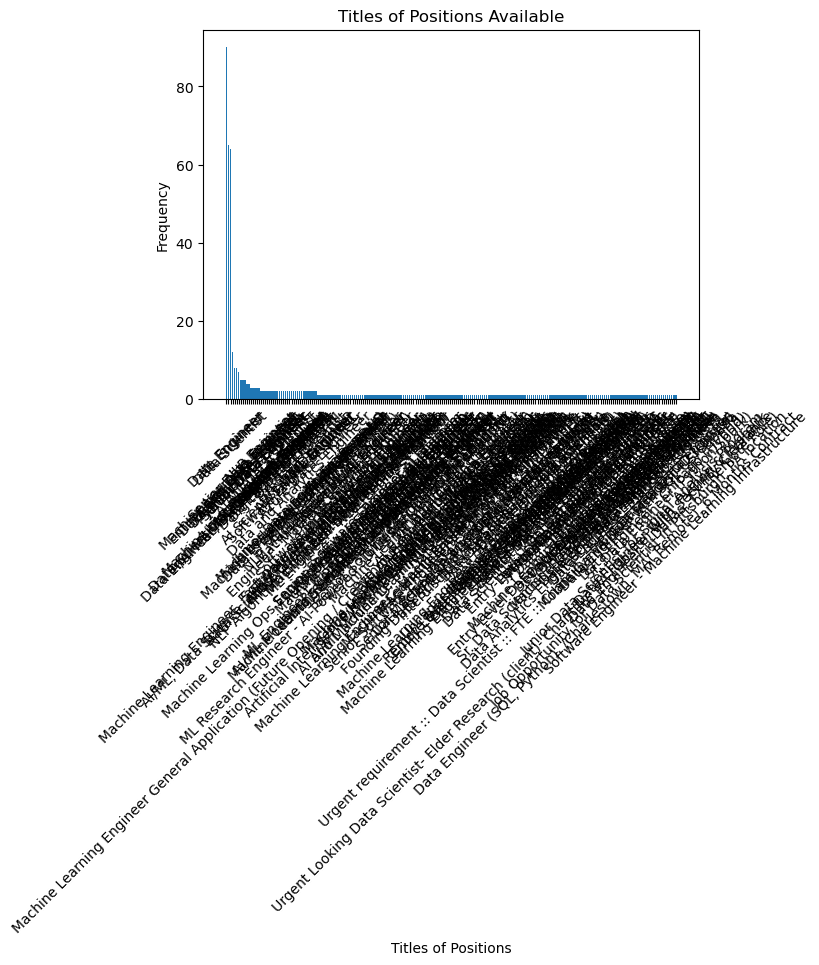

In [ ]:
# Using Matplotlib:
import matplotlib.pyplot as plt

# Assuming 'category' is the column name in your DataFrame
category_counts = df['role'].value_counts()

plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Titles of Positions')
plt.ylabel('Frequency')
plt.title('Titles of Positions Available')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


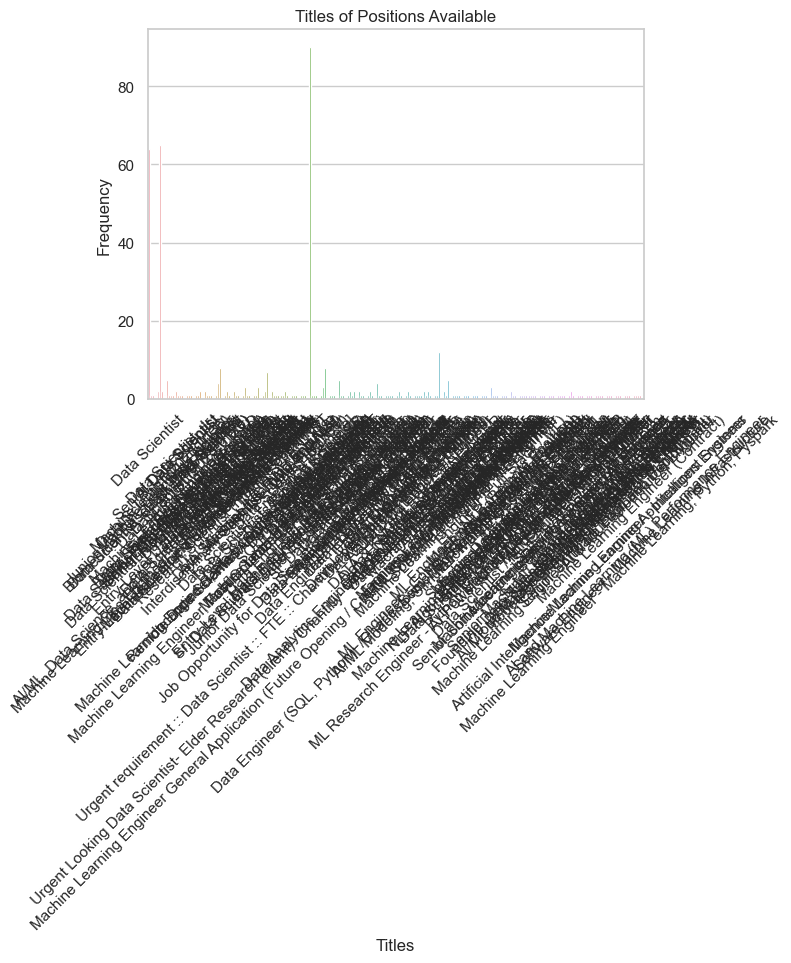

In [ ]:
# Using Seaborn:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")  # Set the style of the plot

# Assuming 'category' is the column name in your DataFrame
sns.countplot(data=df, x='role')
plt.xlabel('Titles')
plt.ylabel('Frequency')
plt.title('Titles of Positions Available')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


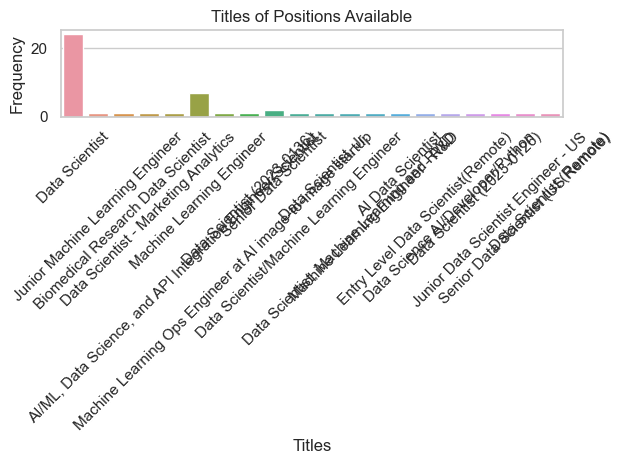

In [ ]:
# Using Seaborn:
# TOP 50 Records
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")  # Set the style of the plot

# Assuming 'category' is the column name in your DataFrame
sns.countplot(data=df.iloc[:50,], x='role')
plt.xlabel('Titles')
plt.ylabel('Frequency')
plt.title('Titles of Positions Available')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


Locations Where Roles Are Offered

In [ ]:
!pip install geopy
!pip install folium

     ------------------------------------- 119.8/119.8 kB 85.5 kB/s eta 0:00:00
     -------------------------------------- 40.3/40.3 kB 113.5 kB/s eta 0:00:00
     ------------------------------------- 102.3/102.3 kB 90.6 kB/s eta 0:00:00


In [ ]:
from geopy.geocoders import Nominatim
import folium

# Create a map centered on the United States
map_center = [37.0902, -95.7129]
m = folium.Map(location=map_center, zoom_start=4)

# Replace this with your actual job data containing city and state names
# job_locations = ['Boston, MA', 'Palo Alto, CA', 'Chicago, IL']
job_locations = df['location'].to_list()

geolocator = Nominatim(user_agent="job_location_geocoder")

for location in job_locations:
    try:
        location_data = geolocator.geocode(location)
        if location_data:
            job_lat = location_data.latitude
            job_lon = location_data.longitude
            folium.Marker([job_lat, job_lon], popup=location).add_to(m)
    except:
        continue

m.save('job_locations_map.html')


Type of Positions

In [ ]:
df.head(1)

,role,company_name,location,hiring_status,job_posting_date,job_link,company_url,no_of_applications,data_pull_time,jd,criterias
0,Data Scientist,Experfy,"San Francisco, CA",None,2023-07-13,https://www.linkedin.com/jobs/view/data-scient...,https://www.linkedin.com/company/experfy?trk=p...,None,2023-08-21 16:14:28.281566,[\n The successful candidate will have ...,"{'Seniority level': 'Mid-Senior level', 'Emplo..."


In [ ]:
criterias_df = pd.json_normalize(df['criterias'])
criterias_df.head(1)

,Seniority level,Employment type,Job function,Industries
0,Mid-Senior level,Full-time,Information Technology,"Technology, Information and Internet"


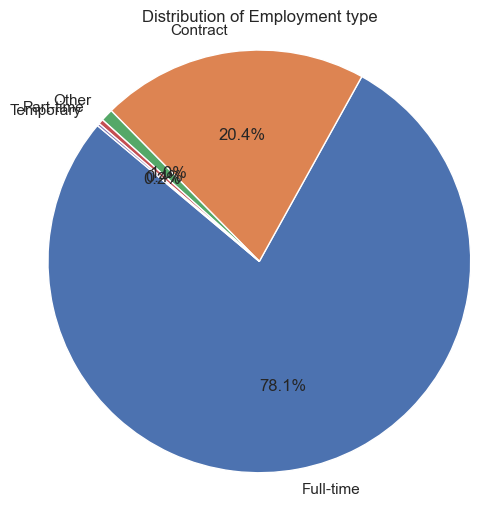

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Calculate category distribution
category_counts = criterias_df['Employment type'].value_counts()

# Create a pie chart
labels = category_counts.index
sizes = category_counts.values

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Employment type')
plt.axis('equal')
plt.show()


3)	Your Ideal Job

In [ ]:
for role, count in df['role'].value_counts().items():
    print(f"{role}: {count}")

Data Engineer: 90
Machine Learning Engineer: 65
Data Scientist: 64
ML Engineer: 12
Entry Level Data Scientist: 8
Data Engineer, Database Engineering: 8
Data Scientist - Freelance [Remote]: 7
Data Engineer (Remote): 5
Senior Data Scientist: 5
Machine Learning Infra Engineer: 5
Data Scientist, Growth: 4
Junior Data Engineer: 4
A/AI Machine Learning Engineer: 3
Python Data Engineer: 3
Senior Data Engineer: 3
Junior Data Scientist: 3
Senior ML Engineer: 3
NLP Engineer: 2
Junior Research Engineer: 2
Machine Learning Engineer, Fast Optimized Inference - US Remote: 2
AI/ML Data Scientist: 2
Data Engineer - Python: 2
ML Solutions Engineer: 2
Machine Learning Engineer General Application (Future Opening / Create Your Own ML Engineer Position): 2
DATA SCIENTIST: 2
Data Engineer/ Analyst: 2
Research Engineer: 2
Junior ML Engineer: 2
Digital Data Engineer: 2
Data Engineer II: 2
AI Scientist, RWD and NLP: 2
AI/ML, Data Science, and API Integration Engineer/Scientist: 2
DATA ENGINEER: 2
Software Eng

In [ ]:
# The ideal job title aspired for is "Data Scientist."